## Import Packages / Load Images

In [4]:
import os, sys, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.widgets as mpwidgets
import seaborn as sns
from IPython.display import Image as IPImage
from PIL import Image, ImageEnhance

## Load Data

In [19]:
img = np.array(Image.open(f"../data/test/test_images_by_pod/9_5.tt8t x fc5-1.B.WBP-2022.W_rep2_9.png"))/ 255
mask = np.array(Image.open(f"../data/test/test_predictions_by_pod/pred_9_5.tt8t x fc5-1.B.WBP-2022.W_rep2_9.png")) / 255

In [20]:
# convert mask background to white
mask[mask.sum(2) == 0] = 1

In [11]:
full_img = np.array(Image.open(f"../data/test/test_images/9_5.tt8t x fc5-1.B.WBP-2022.W_rep2.png"))/ 255
full_mask = np.array(Image.open(f"../data/test/test_predictions/pred_9_5.tt8t x fc5-1.B.WBP-2022.W_rep2.png")) / 255

## Make Mask Viz Function

In [22]:
def mask_viz(image, mask, mask_alpha = 0.5, outlines = False, brighten=True):
  """
  Function to overlay mask on image

  Parameters:
  image (np.array): image to overlay mask on
  mask (np.array): mask to overlay on image
  mask_alpha (float): alpha value for mask overlay
  outlines (bool): whether to draw outlines on mask
  brighten (bool): whether to brighten image before overlay

  Returns:
  masked_image (np.array): image with mask overlay
  """

  # create outlines on each border

  image = image.astype(np.float64)
  mask = mask.astype(np.float64)

  if outlines:
  # create outlines on each border
    outlines = np.zeros_like(mask)
    for i in range(mask.shape[2]):
        channel = np.uint8(mask[:, :, i])
        outlines[:, :, i] = cv2.Canny(channel, 0, 1)

    outlines = np.expand_dims(np.where(outlines.sum(2) > 0 , 255, 0), -1)
    outlines = np.where(outlines > 0, 
                        (mask * 255),
                        0)
    outlines = np.uint8(outlines) / 255

  if brighten:
    # create enhancer
    enhancer = ImageEnhance.Brightness(Image.fromarray((image * 255).astype("uint8")))
    enhanced_im = enhancer.enhance(2)
    enhanced_im = np.array(enhanced_im) /255

  # weighted image
  weighted_image = cv2.addWeighted(image if not brighten else enhanced_im,
                                   (1 - mask_alpha), 
                                   mask, 
                                   mask_alpha, 
                                   0)

  if outlines: 
    weighted_image = np.where(outlines > 0,
                              outlines,
                              weighted_image)

  return weighted_image

## Make Overlay Animation

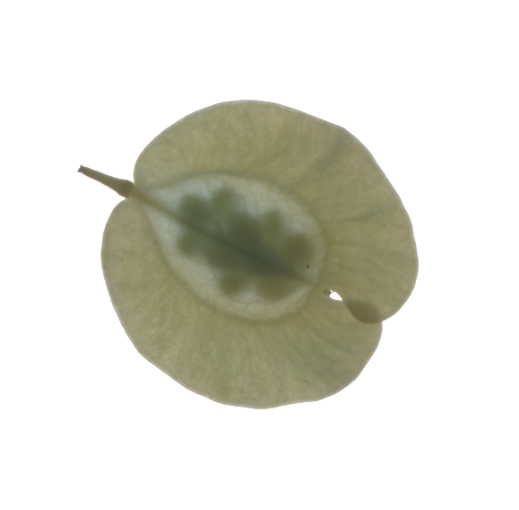

In [24]:
# options
num_frames = 90
f = r'../data/animations/single_mask_fade_animation.gif'

fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
ax.imshow(img)
ax.set_axis_off()

# write a function animate, updating mask_viz with increasing alpha
def animate(frame):
    # halfway through frames, make alpha go back down to 0
    if frame > num_frames / 2:
        alpha = 1 - (frame - num_frames / 2) / (num_frames / 2)
    else:
        alpha = frame / (num_frames / 2)
    masked_image = mask_viz(img, mask, mask_alpha=alpha)

    # clear axis
    ax.clear()
    ax.axis('off')
    ax.imshow(masked_image)
    

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=10000000)
anim.save(f, fps=10)

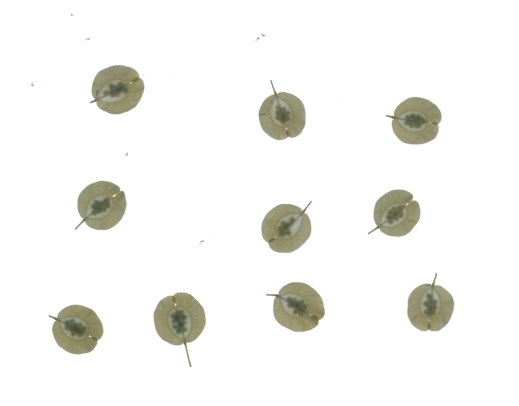

In [26]:
# options
num_frames = 90
f = r'../data/animations/mask_animation.gif'

fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
ax.imshow(full_img)
ax.set_axis_off()

# write a function animate, updating mask_viz with increasing alpha
def animate(frame):
    # halfway through frames, make alpha go back down to 0
    if frame > num_frames / 2:
        alpha = 1 - (frame - num_frames / 2) / (num_frames / 2)
    else:
        alpha = frame / (num_frames / 2)
    masked_image = mask_viz(full_img, full_mask, mask_alpha=alpha)

    # clear axis
    ax.clear()
    ax.axis('off')
    ax.imshow(masked_image)
    

anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=10000000)
anim.save(f, fps=10)

## Make Sliding Door Animation

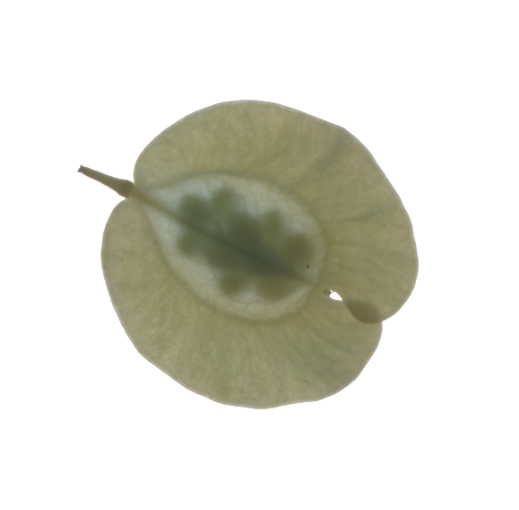

In [31]:
# slide the mask across the image in animation
# options
num_frames = 90
f =`` r'../data/animations/single_slider.gif'

# enhance image
enhancer = ImageEnhance.Brightness(Image.fromarray((img * 255).astype("uint8")))
enhanced_im = enhancer.enhance(2)
enhanced_im = np.array(enhanced_im) / 255

fig, ax = plt.subplots(1,1)
fig.set_size_inches(5,5)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
ax.imshow(enhanced_im)
ax.set_axis_off()

# write a function animate, sliding mask across the image
def animate(frame):

    # halfway through frames, make alpha go back down to 0
    if frame > num_frames / 2:
        alpha = 1 - (frame - num_frames / 2) / (num_frames / 2)
    else:
        alpha = frame / (num_frames / 2)

    # get slider image
    slider = mask[:, :int(mask.shape[1] * alpha),:].copy()

    # add a black line at the end of the slider
    slider[:, -4:, :] = 0
    
    # overlay slider on original image
    overlay = enhanced_im.copy()
    overlay[:, :slider.shape[1], :] = slider

    # clear axis
    ax.clear()
    ax.set_axis_off()
    ax.imshow(enhanced_im)
    ax.imshow(overlay)
    
anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=10000000)
anim.save(f, 
          fps=30, 
          writer='ffmpeg')